In [1]:
#!pip install pennylane-sf pennylane-qiskit pennylane-cirq pennylane-forest pennylane-qsharp


Ensemble classification with Forest and Qiskit devices
=======================================================

.. meta::
    :property="og:description": This demonstration outlines how two QPUs can be
        combined in parallel to help solve a machine learning classification problem,
        using PyTorch and PennyLane.
    :property="og:image": https://pennylane.ai/qml/_images/ensemble_diagram.png

This tutorial outlines how two QPUs can be combined in parallel to help solve a machine learning
classification problem.

We use the ``forest.qvm`` device to simulate one QPU and the ``qiskit.aer`` device to
simulate another. Each QPU makes an independent prediction, and an ensemble model is
formed by choosing the prediction of the most confident QPU. The iris dataset is used in this
tutorial, consisting of three classes of iris flower. Using a pre-trained model and the PyTorch
interface, we'll see that ensembling allows the QPUs to specialize towards
different classes.

Let's begin by importing the prerequisite libraries:


In [4]:
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pennylane as qml
import sklearn.datasets
import sklearn.decomposition
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

This tutorial requires the ``pennylane-forest`` and ``pennylane-qiskit`` packages, which can be
installed by following the instructions `here <https://pennylane.ai/install.html>`__. We also
make use of the `PyTorch interface <https://pennylane.readthedocs.io/en/stable/introduction
/interfaces.html>`_, which can be installed from `here
<https://pytorch.org/get-started/locally/>`__.

Load data
---------

The next step is to load the iris dataset.



In [5]:
n_features = 2
n_classes = 3
n_samples = 150

data = sklearn.datasets.load_iris()
x = data["data"]
y = data["target"]

We shuffle the data and then embed the four features into a two-dimensional space for ease of
plotting later on. The first two principal components of the data are used.



In [6]:
np.random.seed(1967)
x, y = zip(*np.random.permutation(list(zip(x, y))))

pca = sklearn.decomposition.PCA(n_components=n_features)
pca.fit(x)
x = pca.transform(x)

We will be encoding these two features into quantum circuits using :class:`~.pennylane.RX`
rotations, and hence renormalize our features to be between $[-\pi, \pi]$.



In [7]:
x_min = np.min(x, axis=0)
x_max = np.max(x, axis=0)

x = 2 * np.pi * (x - x_min) / (x_max - x_min) - np.pi

The data is split between a training and a test set. This tutorial uses a model that is
pre-trained on the training set.



In [8]:
split = 125

x_train = x[:split]
x_test = x[split:]
y_train = y[:split]
y_test = y[split:]

Finally, let's take a quick look at our data:



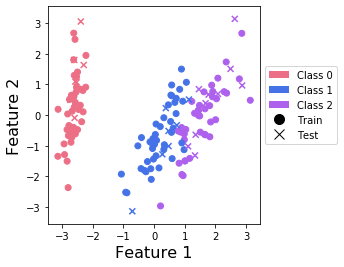

In [9]:
colours = ["#ec6f86", "#4573e7", "#ad61ed"]


def plot_points(x_train, y_train, x_test, y_test):
    c_train = []
    c_test = []

    for y in y_train:
        c_train.append(colours[y])

    for y in y_test:
        c_test.append(colours[y])

    plt.scatter(x_train[:, 0], x_train[:, 1], c=c_train)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=c_test, marker="x")

    plt.xlabel("Feature 1", fontsize=16)
    plt.ylabel("Feature 2", fontsize=16)

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(facecolor=colours[0], edgecolor=c_transparent, label="Class 0"),
        Patch(facecolor=colours[1], edgecolor=c_transparent, label="Class 1"),
        Patch(facecolor=colours[2], edgecolor=c_transparent, label="Class 2"),
        Line2D([0], [0], marker="o", color=c_transparent, label="Train",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker="x", color=c_transparent, label="Test",
               markerfacecolor="black", markersize=10),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))


plot_points(x_train, y_train, x_test, y_test)

This plot shows us that class 0 points can be nicely separated, but that there is an overlap
between points from classes 1 and 2.

Define model
------------

Our model is summarized in the figure below. We use two 4-qubit devices: ``Aspen-4-4Q-F``
from the PennyLane-Forest plugin and ``qiskit.aer`` from the PennyLane-Qiskit plugin.

Data is input using :class:`~.pennylane.RX` rotations and then a different circuit is enacted
for each device with a unique set of trainable parameters. The output of both circuits is a
:class:`~.pennylane.PauliZ` measurement on three of the qubits. This is then fed through a
softmax function, resulting in two 3-dimensional probability vectors corresponding to the 3
classes.

Finally, the ensemble model chooses the QPU which is most confident about its prediction
(i.e., the class with the highest overall probability over all QPUs) and uses that to make a
prediction.

.. figure:: /demonstrations/ensemble_multi_qpu/ensemble_diagram.png
   :width: 50%
   :align: center

Quantum nodes
^^^^^^^^^^^^^

We begin by defining the two quantum devices and the circuits to be run on them.



In [40]:
n_wires = 4

dev0 = qml.device("default.qubit", wires=4) #qml.device("forest.qvm", device="Aspen-4-4Q-F")
dev1 = qml.device("default.qubit", wires=4) #qml.device("qiskit.aer", wires=4)
devs = [dev0, dev1]

<div class="alert alert-info"><h4>Note</h4><p>If you have access to Rigetti hardware, you can swap out ``forest.qvm`` for ``forest.qpu``.
   Users with access to the IBM Q Experience can swap ``qiskit.aer`` for ``qiskit.ibmq`` and
   specify their chosen backend (see `here
   <https://pennylane-qiskit.readthedocs.io/en/latest/gettingstarted.html#ibm-q-experience>`__).</p></div>

<div class="alert alert-danger"><h4>Warning</h4><p>Rigetti's QVM and Quil Compiler services must be running for this tutorial to execute. They
   can be installed by consulting the `Rigetti documentation
   <http://docs.rigetti.com/en/stable/>`__ or, for users with Docker, by running:

   .. code-block:: bash

       docker run -d -p 5555:5555 rigetti/quilc -R -p 5555
       docker run -d -p 5000:5000 rigetti/qvm -S -p 5000</p></div>

The circuits for both QPUs are shown in the figure below:

.. figure:: /demonstrations/ensemble_multi_qpu/diagram_circuits.png
   :width: 50%
   :align: center



In [41]:
def circuit0(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[1, 0, i], wires=i)

    qml.CZ(wires=[1, 0])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[3, 0])

    for i in range(n_wires):
        qml.Rot(*params[1, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))


def circuit1(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[0, 0, i], wires=i)

    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[1, 3])

    for i in range(n_wires):
        qml.Rot(*params[0, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))

We finally combine the two devices into a :class:`~.pennylane.QNodeCollection` that uses the
PyTorch interface:



In [42]:
qnodes = qml.QNodeCollection(
    [qml.QNode(circuit0, dev0, interface="torch"),
     qml.QNode(circuit1, dev1, interface="torch")]
)

Postprocessing into a prediction
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

The ``predict_point`` function below allows us to find the ensemble prediction, as well as keeping
track of the individual predictions from each QPU.

We include a ``parallel`` keyword argument for evaluating the :class:`~.pennylane.QNodeCollection`
in a parallel asynchronous manner. This feature requires the ``dask`` library, which can be
installed using ``pip install "dask[delayed]"``. When ``parallel=True``, we are able to make
predictions faster because we do not need to wait for one QPU to output before running on the
other.



In [43]:
def decision(softmax):
    return int(torch.argmax(softmax))


def predict_point(params, x_point=None, parallel=True):
    results = qnodes(params, x=x_point, parallel=parallel)
    softmax = torch.nn.functional.softmax(results, dim=1)
    choice = torch.where(softmax == torch.max(softmax))[0][0]
    chosen_softmax = softmax[choice]
    return decision(chosen_softmax), decision(softmax[0]), decision(softmax[1]), int(choice)

Next, let's define a function to make a predictions over multiple data points.



In [44]:
def predict(params, x=None, parallel=True):
    predictions_ensemble = []
    predictions_0 = []
    predictions_1 = []
    choices = []

    for i, x_point in enumerate(x):
        if i % 10 == 0 and i > 0:
            print("Completed up to iteration {}".format(i))
        results = predict_point(params, x_point=x_point, parallel=parallel)
        predictions_ensemble.append(results[0])
        predictions_0.append(results[1])
        predictions_1.append(results[2])
        choices.append(results[3])

    return predictions_ensemble, predictions_0, predictions_1, choices

Make predictions
----------------

To test our model, we first load a pre-trained set of parameters which can also be downloaded
by clicking :download:`here <../demonstrations/ensemble_multi_qpu/params.npy>`.



In [45]:
#from google.colab import drive
#drive.mount('/content/drive')

#params = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/params.npy')

params=np.load('params.npy')

We can then make predictions for the training and test datasets.



In [46]:
print("Predicting on training dataset")
p_train, p_train_0, p_train_1, choices_train = predict(params, x=x_train)
print("Predicting on test dataset")
p_test, p_test_0, p_test_1, choices_test = predict(params, x=x_test)

Predicting on training dataset
Completed up to iteration 10
Completed up to iteration 20
Completed up to iteration 30
Completed up to iteration 40
Completed up to iteration 50
Completed up to iteration 60
Completed up to iteration 70
Completed up to iteration 80
Completed up to iteration 90
Completed up to iteration 100
Completed up to iteration 110
Completed up to iteration 120
Predicting on test dataset
Completed up to iteration 10
Completed up to iteration 20


Analyze performance
-------------------

The last thing to do is test how well the model performs. We begin by looking at the accuracy.

Accuracy
^^^^^^^^



In [47]:
def accuracy(predictions, actuals):
    count = 0

    for i in range(len(predictions)):
        if predictions[i] == actuals[i]:
            count += 1

    accuracy = count / (len(predictions))
    return accuracy

In [48]:
print("Training accuracy (ensemble): {}".format(accuracy(p_train, y_train)))
print("Training accuracy (QPU0):  {}".format(accuracy(p_train_0, y_train)))
print("Training accuracy (QPU1):  {}".format(accuracy(p_train_1, y_train)))

Training accuracy (ensemble): 0.832
Training accuracy (QPU0):  0.648
Training accuracy (QPU1):  0.288


In [49]:
print("Test accuracy (ensemble): {}".format(accuracy(p_test, y_test)))
print("Test accuracy (QPU0):  {}".format(accuracy(p_test_0, y_test)))
print("Test accuracy (QPU1):  {}".format(accuracy(p_test_1, y_test)))

Test accuracy (ensemble): 0.72
Test accuracy (QPU0):  0.56
Test accuracy (QPU1):  0.24


These numbers tell us a few things:

- On both training and test datasets, the ensemble model outperforms the predictions from each
  QPU. This provides a nice example of how QPUs can be used in parallel to gain a performance
  advantage.

- The accuracy of QPU0 is much higher than the accuracy of QPU1. This does not mean that one
  device is intrinsically better than the other. In fact, another set of parameters can lead to
  QPU1 becoming more accurate. We will see in the next section that the difference in accuracy
  is due to specialization of each QPU, which leads to overall better performance of the
  ensemble model.

- The test accuracy is lower than the training accuracy. Here our focus is on analyzing the
  performance of the ensemble model, rather than minimizing the generalization error.

Choice of QPU
^^^^^^^^^^^^^

Is there a link between the class of a datapoint and the QPU chosen to make the prediction in
the ensemble model? Let's investigate.



In [23]:
# Combine choices_train and choices_test to simplify analysis
choices = np.append(choices_train, choices_test)
print("Choices: {}".format(choices))
print("Choices counts: {}".format(Counter(choices)))

Choices: [0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 0]
Choices counts: Counter({0: 111, 1: 39})


The following lines keep track of choices and corresponding predictions in the ensemble model.



In [24]:
predictions = np.append(p_train, p_test)
choice_vs_prediction = np.array([(choices[i], predictions[i]) for i in range(n_samples)])

We can hence find the predictions each QPU was responsible for.



In [25]:
choices_vs_prediction_0 = choice_vs_prediction[choice_vs_prediction[:, 0] == 0]
choices_vs_prediction_1 = choice_vs_prediction[choice_vs_prediction[:, 0] == 1]
predictions_0 = choices_vs_prediction_0[:, 1]
predictions_1 = choices_vs_prediction_1[:, 1]


expl = "When QPU{} was chosen by the ensemble, it made the following distribution of " \
       "predictions:\n{}"
print(expl.format("0", Counter(predictions_0)))
print("\n" + expl.format("1", Counter(predictions_1)))
print("\nDistribution of classes in iris dataset: {}".format(Counter(y)))

When QPU0 was chosen by the ensemble, it made the following distribution of predictions:
Counter({2: 56, 0: 55})

When QPU1 was chosen by the ensemble, it made the following distribution of predictions:
Counter({1: 36, 0: 3})

Distribution of classes in iris dataset: Counter({0: 50, 2: 50, 1: 50})


These results show us that QPU0 specializes to making predictions on classes 0 and 2,
while QPU1 specializes to class 1.

Visualization
^^^^^^^^^^^^^

We conclude by visualizing the correct and incorrect predictions on the dataset. The following
function plots correctly predicted points in green and incorrectly predicted points in red.



In [26]:
colours_prediction = {"correct": "#83b5b9", "incorrect": "#f98d91"}
markers = ["o", "v", "d"]


def plot_points_prediction(x, y, p, title):
    c = {0: [], 1: [], 2: []}
    x_ = {0: [], 1: [], 2: []}

    for i in range(n_samples):
        x_[y[i]].append(x[i])
        if p[i] == y[i]:
            c[y[i]].append(colours_prediction["correct"])
        else:
            c[y[i]].append(colours_prediction["incorrect"])

    for i in range(n_classes):
        x_class = np.array(x_[i])
        plt.scatter(x_class[:, 0], x_class[:, 1], c=c[i], marker=markers[i])

    plt.xlabel("Feature 1", fontsize=16)
    plt.ylabel("Feature 2", fontsize=16)
    plt.title("Predictions from {} model".format(title))

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(
            facecolor=colours_prediction["correct"],
            edgecolor=c_transparent, label="Correct"
        ),
        Patch(
            facecolor=colours_prediction["incorrect"],
            edgecolor=c_transparent, label="Incorrect"
        ),
        Line2D([0], [0], marker=markers[0], color=c_transparent, label="Class 0",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker=markers[1], color=c_transparent, label="Class 1",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker=markers[2], color=c_transparent, label="Class 2",
               markerfacecolor="black", markersize=10),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))

We can again compare the ensemble model with the individual models from each QPU.



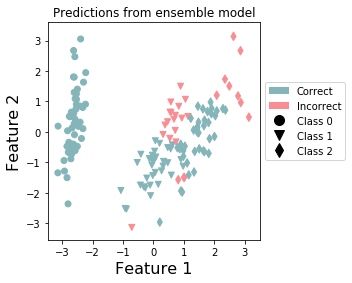

In [27]:
plot_points_prediction(x, y, predictions, "ensemble")  # ensemble

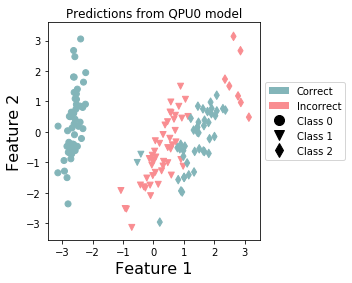

In [28]:
plot_points_prediction(x, y, np.append(p_train_0, p_test_0), "QPU0")  # QPU 0

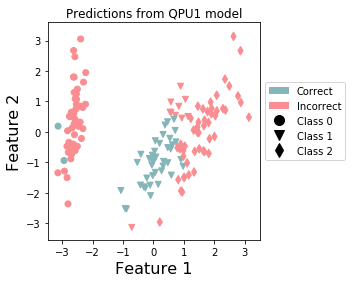

In [29]:
plot_points_prediction(x, y, np.append(p_train_1, p_test_1), "QPU1")  # QPU 1

These plots reinforce the specialization of the two QPUs. QPU1 concentrates on doing a good job
at predicting class 1, while QPU0 is focused on classes 0 and 2. By combining together,
the resultant ensemble performs better.

This tutorial shows how QPUs can work in parallel to realize a performance advantage. Check out
our :doc:`tutorial_vqe_parallel` tutorial to see how multiple QPUs can be
evaluated asynchronously to speed up calculating the potential energy surface of molecular
hydrogen!

